In [2]:
import seaborn as sns
import collections as col
import pandas as pd
import statistics
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from typing import Union
from pathlib import Path
import gseapy as gp
import functions_sheet as myfunc
from gseapy import barplot, dotplot
import re
import upsetplot as usp
from collections import Counter
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
from gseapy import Msigdb
path_to_main_comparison_dir = "/nfs/data3/IHEC/TF_PRIO/comparisons/cells"
path_to_all_tfs_file = "/nfs/data3/IHEC/TF_PRIO/additional_files/all_tfs.txt"
path_to_figure_folder = "/nfs/data3/IHEC/TF_PRIO/created_plots/5_unique_condition_specific_TFs"

- creating df with set of every top / condition-specific TF for active and suppressive marks </br>
- adding intersection & other columns but remove except but unique because they're not needed

In [3]:
tf_overlap_df_tpm = myfunc.create_overlap_df_with_tpm(path_to_main_comparison_dir, tpm_filter=1)
tf_overlap_df_tpm_changed = myfunc.add_overlap_union_unique_shared_with_all_or_once(tf_overlap_df_tpm)
tf_df_tpm_unique = tf_overlap_df_tpm_changed[["unique"]]

Displaying the sizes of the unique TF sets

In [4]:
tf_df_tpm_unique.applymap(lambda x: len(x))

,unique
macrophage-healthy-neutrophil-healthy,0
macrophage-healthy-monocyte-healthy,6
b-cells-healthy-t-cell-healthy,1
macrophage-healthy-t-cell-healthy,0
b-cells-healthy-monocyte-healthy,1
monocyte-healthy-neutrophil-healthy,0
t-cell-healthy-neutrophil-healthy,2
b-cells-healthy-macrophage-healthy,1
b-cells-healthy-b-cells-leukemia,8
monocyte-healthy-t-cell-healthy,2


# Show which TFs have a TPM >= 1 for which cell type
So when condutcing a literature research and finding e.g. a relation for TF X with celltye Y but in the data, the TF has a TPM of min 1 just for cell type Z but not for Y, than this relation would be deemed inconsequential

creating a dataframe that holds all genes that have a TPM value  of at least 1 for each cell type

In [21]:
tpm_df = myfunc.get_tpm_filtered_genes_df(path_to_main_comparison_dir, tpm_filter=1)
tpm_df["length"] = tpm_df["TPM_filtered_genes"].apply(lambda x: len(x))

displaying the df for a short overview of the set sizes

In [8]:
tpm_df

,TPM_filtered_genes,length
celltype,,
neutrophil-healthy,"{ARHGEF2, RPL23, RF01877, MTMR1, DEGS1, ERAP1,...",7211
macrophage-healthy,"{ARHGEF2, RPL23, MTMR1, DEGS1, ERAP1, TNRC18P1...",9715
monocyte-healthy,"{ARHGEF2, RPL23, RF01877, MTMR1, DEGS1, ERAP1,...",10447
b-cells-healthy,"{ARHGEF2, RPL23, RF01877, MTMR1, DEGS1, ERAP1,...",11091
t-cell-healthy,"{ARHGEF2, RPL23, RF01877, MTMR1, DEGS1, ERAP1,...",10170
b-cells-leukemia,"{ARHGEF2, RPL23, RF01877, MTMR1, DEGS1, ERAP1,...",14447


Creating a mapping dataframe that creates a dictionary for each of the rows, in which for each of the unique TFs a list of the at max 2 respective cell types, for which the TF has a TPM value of at least 1, is created

In [23]:
# creating the tf-tpm-mapping by using apply rowwise:
# creates a dictionary with each tf as key and a list, using a list comprehension that puts each celltype in the list if the tf is in the list of tpm-filtered genes in the tpm_df AND if the celltype is a substring of the rowindex (row.name)
tf_df_tpm_unique_mapping = pd.DataFrame()
tf_df_tpm_unique_mapping['tf_tpm_mapping'] = tf_df_tpm_unique.apply(lambda row: {tf: [celltype for celltype, all_tpm_genes in tpm_df['TPM_filtered_genes'].items() if (any(tpm_gene in tf for tpm_gene in all_tpm_genes) & (celltype in row.name))] for tf in row["unique"]},axis=1)


In [24]:
tf_df_tpm_unique_mapping

,tf_tpm_mapping
macrophage-healthy-neutrophil-healthy,{}
macrophage-healthy-monocyte-healthy,"{'DBP': ['macrophage-healthy', 'monocyte-healt..."
b-cells-healthy-t-cell-healthy,"{'GFI1': ['b-cells-healthy', 't-cell-healthy']}"
macrophage-healthy-t-cell-healthy,{}
b-cells-healthy-monocyte-healthy,"{'ELF2': ['monocyte-healthy', 'b-cells-healthy']}"
monocyte-healthy-neutrophil-healthy,{}
t-cell-healthy-neutrophil-healthy,"{'STAT1': ['neutrophil-healthy', 't-cell-healt..."
b-cells-healthy-macrophage-healthy,"{'ZFP14': ['macrophage-healthy', 'b-cells-heal..."
b-cells-healthy-b-cells-leukemia,"{'MYB': ['b-cells-leukemia'], 'TBX6': ['b-cell..."
monocyte-healthy-t-cell-healthy,"{'ZKSCAN1': ['monocyte-healthy', 't-cell-healt..."


Flattening the values and keys of each dictionary so that each "unique TF - cell types with TPM >= 1" pair are represented in 1 row to make the assigned cell types for each TF better visible

In [19]:
tf_df_tpm_unique_mapping = tf_df_tpm_unique_mapping["tf_tpm_mapping"].apply(pd.Series)
mapping_df_expanded = tf_df_tpm_unique_mapping.reset_index()
mapping_df_melt = mapping_df_expanded.melt(id_vars='index', var_name='TF',value_name='TPM_over_1_in_celltype').dropna().sort_values('index')
mapping_df_melt

,index,TF,TPM_over_1_in_celltype
140,b-cells-healthy-b-cells-leukemia,TBX6,[b-cells-leukemia]
206,b-cells-healthy-b-cells-leukemia,SPIB,"[b-cells-healthy, b-cells-leukemia]"
195,b-cells-healthy-b-cells-leukemia,HESX1,[b-cells-leukemia]
184,b-cells-healthy-b-cells-leukemia,KLF14,[b-cells-leukemia]
173,b-cells-healthy-b-cells-leukemia,HOXB7,[b-cells-leukemia]
162,b-cells-healthy-b-cells-leukemia,TEAD2,[b-cells-leukemia]
151,b-cells-healthy-b-cells-leukemia,HOXA5,[b-cells-leukemia]
129,b-cells-healthy-b-cells-leukemia,MYB,[b-cells-leukemia]
117,b-cells-healthy-macrophage-healthy,ZFP14,"[macrophage-healthy, b-cells-healthy]"
81,b-cells-healthy-monocyte-healthy,ELF2,"[monocyte-healthy, b-cells-healthy]"


Conducting a literature research for the TFs

macrophage-healthy-monocyte-healthy <br />
- HES6 -> nothing<br /> 
- DBP -> nothing<br /> 
- ETV5::HOXA2 <br />
-> as dimer and for HOXA2, in relation with monocytes/macrophages, found nothing <br />
For ETV5 - related pathways are IL12-mediated signaling (https://www.genecards.org/cgi-bin/carddisp.pl?gene=ETV5) <br />
-> IL12 is a interleukin thats produced by  dendritic cells, macrophages, neutrophils,T cell and B cells in response to antigenic stimulation
- ZBTB18 <br />
-> maybe: https://doi.org/10.1038/s41392-023-01727-7 (macro)
- ZNF454 -> nothing<br />
- ZNF701 -> nothing<br /> 
- SOX12 -> nothin<br />

b-cells-healthy-t-cell-healthy  <br />
- GFI1 hit<br />
https://www.genecards.org/cgi-bin/carddisp.pl?gene=GFI1 <br />
B-cell:<br />
https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0000306 <br />
https://ashpublications.org/blood/article/116/7/1060/27690/Repression-of-Id2-expression-by-Gfi-1-is-required 
-> usable example for target gene affinity <br />
T-cell:<br />
https://www.nature.com/articles/1205216?error=cookies_not_supported&code=3290fe0f-2fac-43e4-9fe9-ed6dfa7988b1 <br />
https://rupress.org/jem/article/197/7/831/39700/The-Transcriptional-Repressor-Gfi1-Affects <br />
https://www.pnas.org/doi/abs/10.1073/pnas.93.25.14569 <br />
https://academic.oup.com/nar/article/32/8/2508/2904550?login=false<br />

macrophage-healthy-t-cell-healthy <br />
- DMRTC2 -> nothing <br />

b-cells-healthy-monocyte-healthy <br />
- ELF2 -> maybe <br />
Among its related pathways are Gene expression (Transcription) and Immune response IL-23 signaling pathway.
https://www.genecards.org/cgi-bin/carddisp.pl?gene=ELF2 <br />
- MLXIPL ->nothing <br />

t-cell-healthy-neutrophil-healthy <br />
- STAT1 -> maybe <br />
https://www.genecards.org/cgi-bin/carddisp.pl?gene=STAT1 (didnot found paper  with relation to t-cellor neutrophil)
- JUNB -> not directly but via AP-1<br />
Regulation of T cell differentiation by the AP-1 transcription factor JunB https://www.tandfonline.com/doi/full/10.1080/25785826.2021.1872838?cookieSet=1 

b-cells-healthy-macrophage-healthy <br />
- ZFP14 -> nothing <br />
- TFAP4::ETV1 -> maybe maybe<br />
Nothing on both, for ETV1:<br />
ETV1 inhibition depressed M2 polarization of tumor-associated macrophage and cell process in gastrointestinal stromal tumor via down-regulating PDE3A https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10017324/ <br />

b-cells-healthy-b-cells-leukemia <br />
- HOXB7 <br /> ->  nothing
- HESX1 <br /> -> nothing
- MYCN <br />
- TBX6 <br />
- TEAD2 <br />
- HOXA5 <br /> -> potential therapeutic target
- SPIB <br />
ETV6-RUNX1 interacts with a region in SPIB intron 1 to regulate gene expression in pre-B-cell acute lymphoblastic leukemia https://www.sciencedirect.com/science/article/pii/S0301472X19301341 <br />
Expression and Clinical Significance of Spi-B in B-cell Acute Lymphoblastic Leukemia https://journals.sagepub.com/doi/full/10.1369/00221554221130383 <br />
- MYB <br /> -> potential tehrapeutic target

monocyte-healthy-t-cell-healthy <br />
- ZKSCAN1 -> nothing<br />
- STAT1::STAT2 <br />
"STAT1 and STAT2 are key components of the transcription factor complex in the IFN signaling pathways"
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3772101/<br />
(monocyte) 
https://journals.aai.org/jimmunol/article-abstract/159/2/794/110756/Interferons-up-regulate-STAT1-STAT2-and-IRF-family <br />

b-cells-healthy-neutrophil-healthy <br />
- PLAG1 -> nothing<br />
- SPI1 <br />
This gene encodes an ETS-domain transcription factor that activates gene expression during myeloid and B-lymphoid cell development. https://www.genecards.org/cgi-bin/carddisp.pl?gene=SPI1
- EGR1 <br />
- CEBPG <br />

In [15]:
tf_df_tpm_unique.at["b-cells-healthy-b-cells-leukemia","unique"]

{'HESX1', 'HOXA5', 'HOXB7', 'KLF14', 'MYB', 'SPIB', 'TBX6', 'TEAD2'}

As MYB is chosen as example and because its also a potential therapeutic target,its inspected if its, as it shopuld be the case, from the active marker set

In [54]:
print("MYB" in tf_overlap_df_tpm_changed.loc["b-cells-healthy-b-cells-leukemia", "active_markers"])
print("MYB" in tf_overlap_df_tpm_changed.loc["b-cells-healthy-b-cells-leukemia", "suppressive_markers"])

True
False


# ORA on TFs

In [5]:
all_tfs = pd.read_csv(path_to_all_tfs_file, sep="\t").columns.values
all_tfs_adjusted = myfunc.adjust_tfprio_used_TF(all_tfs)

In [6]:
msig = Msigdb()

# cancer related gene sets:
MSigDB_computational = msig.get_gmt(category='c4.all', dbver="2023.2.Hs")
MSigDB_oncogenic_Signatures = msig.get_gmt(category='c6.all', dbver="2023.2.Hs")
gseapy_nci_cancer_cell_line = gp.get_library(name='NCI-60_Cancer_Cell_Lines', organism='Human')
gseapy_cancer_cell_line_encyclopedia = gp.get_library(name='Cancer_Cell_Line_Encyclopedia', organism='Human')

cancer_gene_sets = [MSigDB_computational, MSigDB_oncogenic_Signatures, gseapy_nci_cancer_cell_line, gseapy_cancer_cell_line_encyclopedia]

# normal gene sets
MSigDB_regulatory_target = msig.get_gmt(category='c3.all', dbver="2023.2.Hs")
MSigDB_GO = msig.get_gmt(category='c5.go', dbver="2023.2.Hs")
MSigDB_immunologic_signature = msig.get_gmt(category='c7.immunesigdb', dbver="2023.2.Hs")
MSigDB_cell_type = msig.get_gmt(category='c8.all', dbver="2023.2.Hs")
MSigDB_hallmarks = msig.get_gmt(category='h.all', dbver="2023.2.Hs")
gseapy_cell_marker_augmented = gp.get_library(name='CellMarker_Augmented_2021', organism='Human')
kegg = gp.get_library(name='KEGG_2021_Human', organism='Human')

normal_gene_sets = [MSigDB_regulatory_target, MSigDB_immunologic_signature, MSigDB_cell_type, 
                    MSigDB_GO, MSigDB_hallmarks, gseapy_cell_marker_augmented, kegg]

In [7]:
normal_gene_sets_renaming = {
                            "gs_ind_0": "MSigDB_Regulatory_Targets_2023",
                            "gs_ind_1": "MSigDB_Immunologic_Signatures_2023",
                            "gs_ind_2": "MSigDB_Cell_Type_Signatures_2023",
                            "gs_ind_3": "MSigDB_Gene_Ontology_2023",
                            "gs_ind_4": "MSigDB_Hallmark_2023",
                            "gs_ind_5": "CellMarker_Augmented_2021",
                            "gs_ind_6": "KEGG_2021_Human"}
cancer_gene_sets_renaming = {
                            "gs_ind_0": "MSigDB_Computational_2023",
                            "gs_ind_1": "MSigDB_Oncogenic_Signatures_2023",
                            "gs_ind_2": "NCI-60_Cancer_Cell_Lines",
                            "gs_ind_3": "Cancer_Cell_Line_Encyclopedia"}

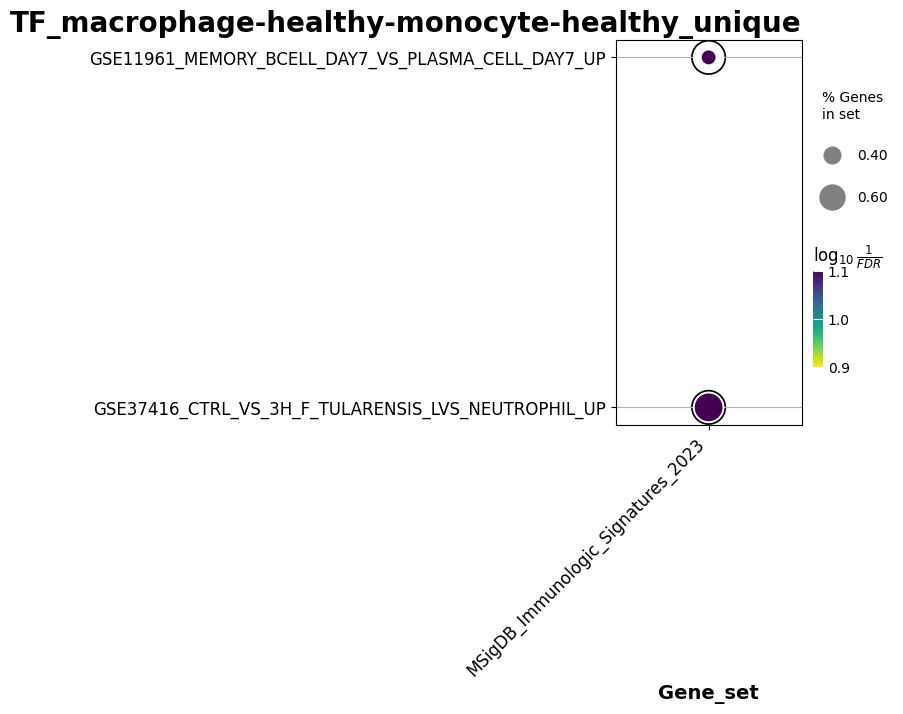

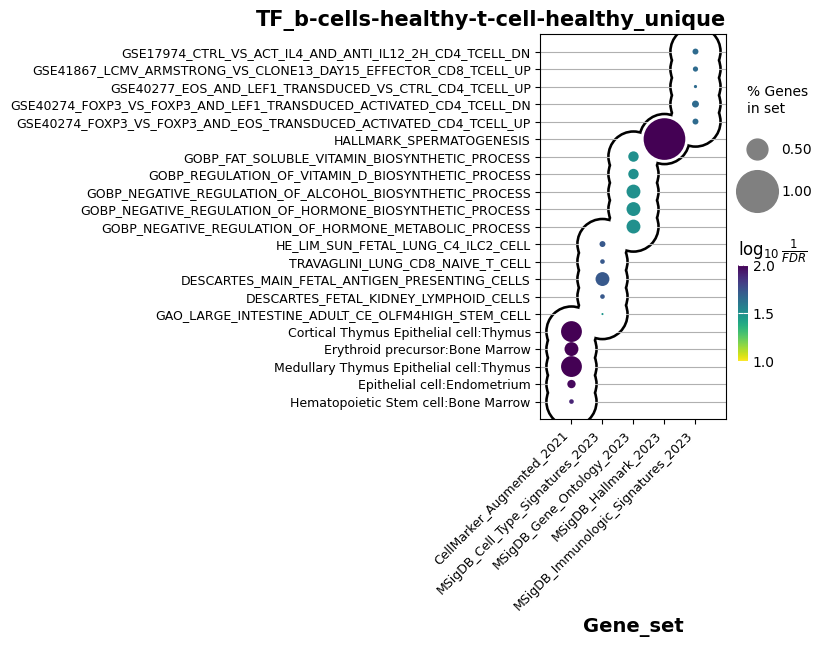

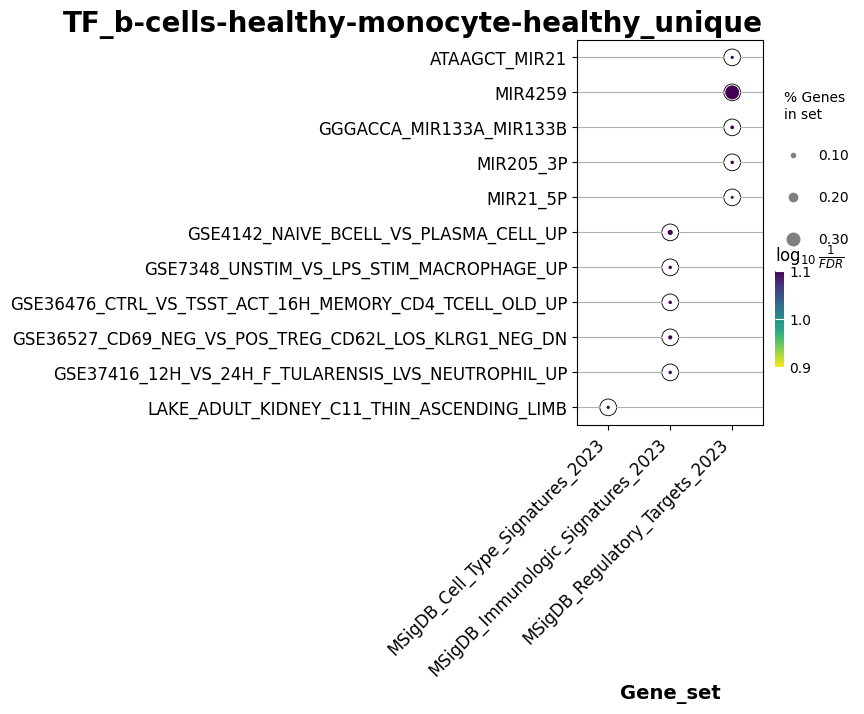

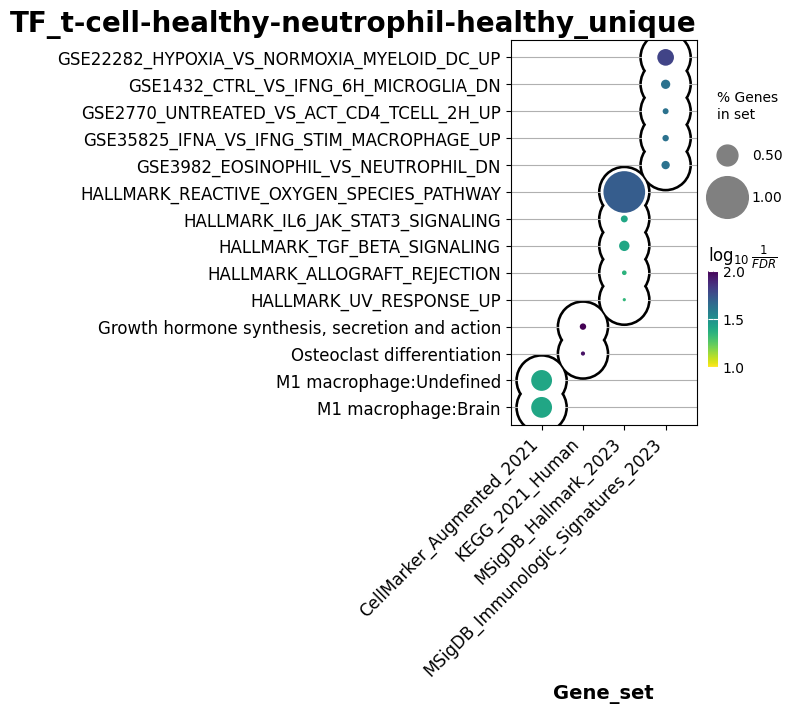

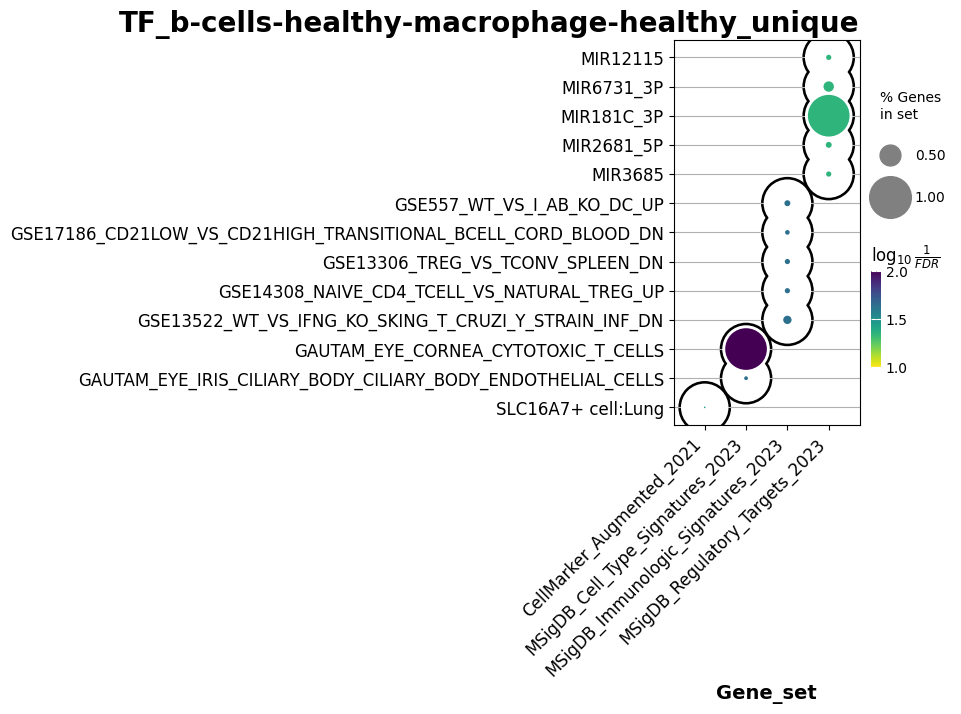

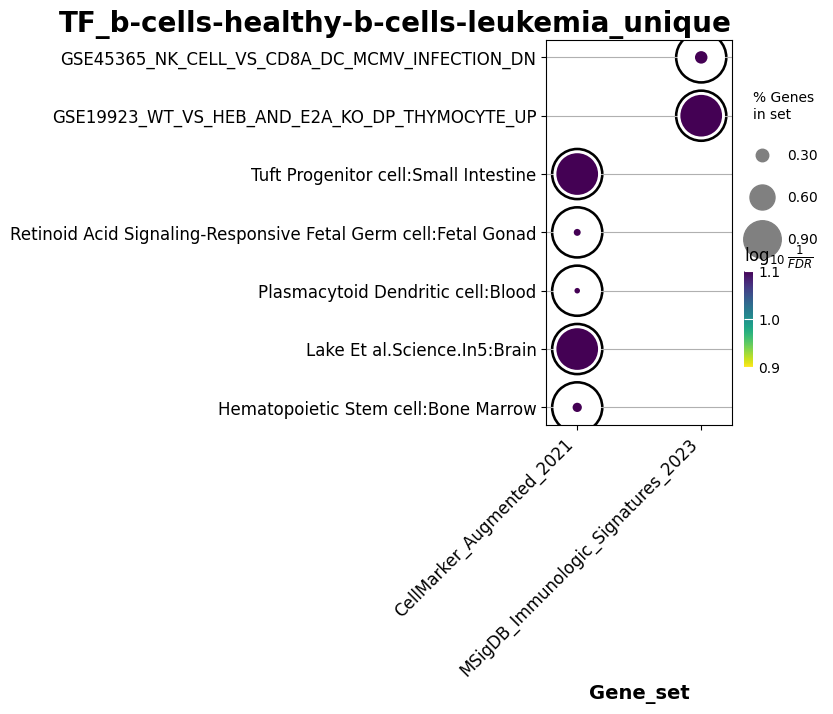

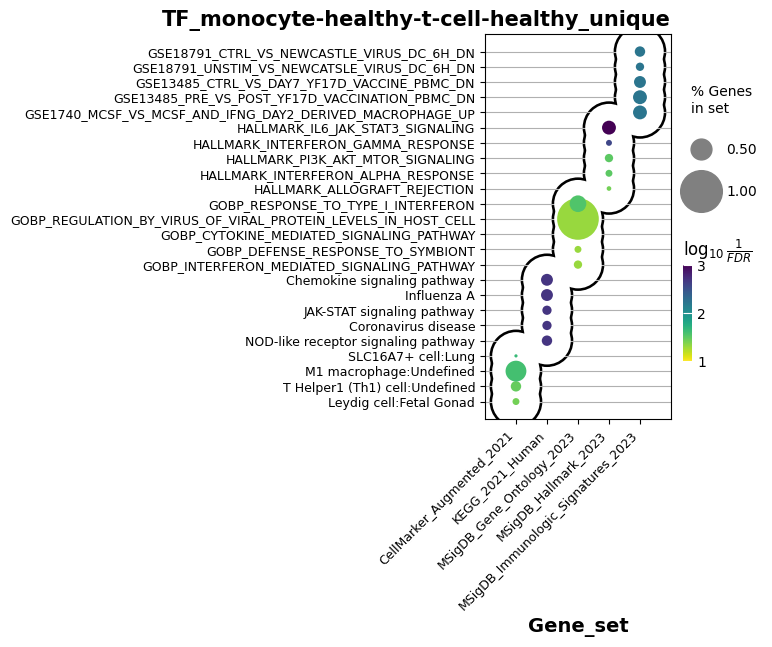

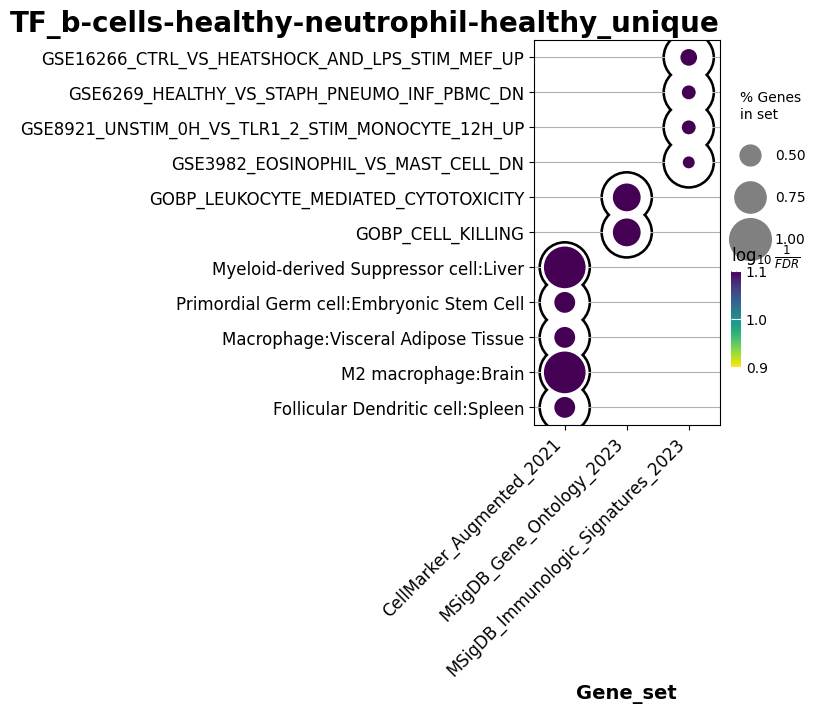

In [9]:
tf_results_dictionary = {}
for index, row in tf_df_tpm_unique.iterrows():
    for tf_type in tf_df_tpm_unique.columns:
        if len(row["unique"]) > 0:
            genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
            enr_bg = gp.enrichr(gene_list=genes,
                            gene_sets=normal_gene_sets,
                            #organism='human', # organism argment is ignored because user input a background
                            background=all_tfs_adjusted,
                            outdir=None, # don't write to disk
                            )
            enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(normal_gene_sets_renaming)
            try:
                    
                    ax = gp.dotplot(enr_bg.results,
                                column="Adjusted P-value",
                                x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                                size=5,
                                top_term=5,
                                figsize=(3,5),
                                xticklabels_rot=45, # rotate xtick labels
                                show_ring=True, # set to False to revmove outer ring
                                marker='o',
                                )
                    x_axis_size, y_axis_size, title_size = myfunc.enrichr_adjust_axis_title_font_sizes(enr_bg.results)
                    ax.tick_params(axis='y', labelsize=y_axis_size)
                    ax.tick_params(axis='x', labelsize=x_axis_size)
                    ax.set_title("TF_"+index+"_"+tf_type, loc="right", fontsize=title_size,fontweight='bold')
                    figure_file_name = "ORA_TF_"+index+"_"+tf_type
                    plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                    tf_results_dictionary[index] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index))
                print(ve)

In [11]:
leukemia_unique_tf_df = tf_df_tpm_unique.loc[["b-cells-healthy-b-cells-leukemia"],:]

In [12]:
tf_leukemia_results_dictionary = {}
for index, row in leukemia_unique_tf_df.iterrows():
    for tf_type in leukemia_unique_tf_df.columns:
        if len(row["unique"]) > 0:
            genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
            enr_bg = gp.enrichr(gene_list=genes,
                            gene_sets=cancer_gene_sets,
                            #organism='human', # organism argment is ignored because user input a background
                            background=all_tfs_adjusted,
                            outdir=None, # don't write to disk
                            )
            enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(cancer_gene_sets_renaming)
            try:
                    ax = gp.dotplot(enr_bg.results,
                                column="Adjusted P-value",
                                x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                                size=5,
                                top_term=5,
                                figsize=(3,5),
                                xticklabels_rot=45, # rotate xtick labels
                                show_ring=True, # set to False to revmove outer ring
                                marker='o',
                                )
                    y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
                    ax.tick_params(axis='y', labelsize=y_axis_size)
                    ax.set_title("TF_"+index+"_"+tf_type, loc="right", fontsize=title_size,fontweight='bold')
                    figure_file_name = "ORA_TF_"+index+"_"+tf_type
                    #plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                    tf_leukemia_results_dictionary[index] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index))
                print(ve)

For b-cells-healthy-b-cells-leukemia


In [44]:
results_dictionary_databases["b-cells-healthy-b-cells-leukemia"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes,Old P-value,Old adjusted P-value
0,gs_ind_0,AAAGGAT_MIR501,1/15,0.156930,0.386914,9.551724,17.689367,MYB,NaN,NaN
1,gs_ind_0,AAAYRNCTG_UNKNOWN,2/36,0.057162,0.347837,7.497213,21.456019,HOXA5;HESX1,NaN,NaN
2,gs_ind_0,AAAYWAACM_HFH4_01,1/41,0.378430,0.426947,3.291358,3.198288,HESX1,NaN,NaN
3,gs_ind_0,AACTTT_UNKNOWN,5/210,0.052508,0.345285,3.834897,11.300630,HOXB7;HOXA5;TEAD2;SPIB;HESX1,NaN,NaN
4,gs_ind_0,AACYNNNNTTCCS_UNKNOWN,2/10,0.004732,0.345285,31.606335,169.203716,HOXA5;TBX6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1497,NCI-60_Cancer_Cell_Lines,MOLT4,NaN,0.249163,0.373744,4.059524,5.641317,MYB,0.0,0.0
1498,NCI-60_Cancer_Cell_Lines,CCRT CEM,NaN,0.360292,0.404688,1.825688,1.863735,MYCN;TBX6,0.0,0.0
1499,NCI-60_Cancer_Cell_Lines,NCI H23,NaN,0.363419,0.404688,2.511278,2.541913,MYCN,0.0,0.0
1500,NCI-60_Cancer_Cell_Lines,RL7,NaN,0.370964,0.404688,2.443223,2.422825,SPIB,0.0,0.0


# GSEA  on TFs

A gsea is not feasible  for these TFs as the unique TFs can either come from the active or suppressive mark comparisons, which would lead require to use different TF-prio scores which would make a performance of a GSEA meaningless

# target genes of the TFs

In [13]:
gtf_dict = myfunc.read_gtf_and_create_ensg_hgnc_dict()

In [15]:
df_top_k_tg_unique = myfunc.read_out_filtered_target_genes_df(tf_df_tpm_unique, path_to_main_comparison_dir)
df_all_tg_unique = myfunc.read_out_filtered_target_genes_df(tf_df_tpm_unique, path_to_main_comparison_dir, modus="all_genes")

In [16]:
df_top_k_tg_unique_hgnc = df_top_k_tg_unique.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))
df_all_tg_unique_hgnc = df_all_tg_unique.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))
#

Looking at the sizes of the resulting TG sets

In [17]:
df_top_k_tg_unique_hgnc.applymap(lambda x: len(x))

,unique
b-cells-healthy-b-cells-leukemia,0
b-cells-healthy-macrophage-healthy,0
b-cells-healthy-monocyte-healthy,0
b-cells-healthy-neutrophil-healthy,0
b-cells-healthy-t-cell-healthy,0
macrophage-healthy-monocyte-healthy,1
macrophage-healthy-neutrophil-healthy,0
macrophage-healthy-t-cell-healthy,0
monocyte-healthy-neutrophil-healthy,0
monocyte-healthy-t-cell-healthy,0


In [18]:
df_all_tg_unique_hgnc.applymap(lambda x: len(x))

,unique
b-cells-healthy-b-cells-leukemia,0
b-cells-healthy-macrophage-healthy,0
b-cells-healthy-monocyte-healthy,0
b-cells-healthy-neutrophil-healthy,0
b-cells-healthy-t-cell-healthy,0
macrophage-healthy-monocyte-healthy,5
macrophage-healthy-neutrophil-healthy,0
macrophage-healthy-t-cell-healthy,0
monocyte-healthy-neutrophil-healthy,0
monocyte-healthy-t-cell-healthy,0


Literature research on the TGs as they are so few it is feasible

macrophage-healthy-monocyte-healthy	<br />
- ENSG00000259771 -> lncRNA https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENSG00000259771
- ENSG00000218582 -> Pseudogene https://www.genecards.org/cgi-bin/carddisp.pl?gene=GAPDHP63, 
http://angiogenes.uni-frankfurt.de/gene/ENSG00000218582
- ENSG00000118402 -> ELOVL4 https://www.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000118402;r=6:79914814-79947553;t=ENST00000369816 <br />
-> no connection with monocytes or macrophages found
- ENSG00000224661 -> lncRNA https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENSG00000224661
- ENSG00000214866 -> coding Gene https://www.genecards.org/cgi-bin/carddisp.pl?gene=DCDC2C <br />
-> no connection with monocytes or macrophages found

t-cell-healthy-neutrophil-healthy	<br />
- ENSG00000249426 -> lncRNA https://www.genecards.org/cgi-bin/carddisp.pl?gene=ENSG00000249426 

## ORA top K TGs
Cannot be performed as for the ORA needs at least 2 genes as input, otherwise a "ValueError: No objects to concatenate" will be thrown  

In [30]:
top_k_tg_results_dictionary = {}
for index, row in df_top_k_tg_unique_hgnc.iterrows():
    for tf_type in df_top_k_tg_unique_hgnc.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
        if len(genes) > 0:
            try:
                enr_bg = gp.enrichr(gene_list=genes,
                            gene_sets=normal_gene_sets,
                            organism='human', 
                            #background=all_tfs_adjusted,
                            outdir=None, # don't write to disk
                            )
                enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(normal_gene_sets_renaming)
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            #title = index+"_"+tf_type,
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=y_axis_size)
                ax.tick_params(axis='x', labelsize=y_axis_size)
                ax.set_title("all_TG_"+index+"_"+tf_type, loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_all_TG_"+index+"_"+tf_type
                #plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                top_k_tg_results_dictionary[index+"_"+tf_type] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+tf_type)
                print(ve)

For macrophage-healthy-monocyte-healthy_unique
No objects to concatenate
For t-cell-healthy-neutrophil-healthy_unique
No objects to concatenate


## ORA all TGs

For t-cell-healthy-neutrophil-healthy_unique
No objects to concatenate


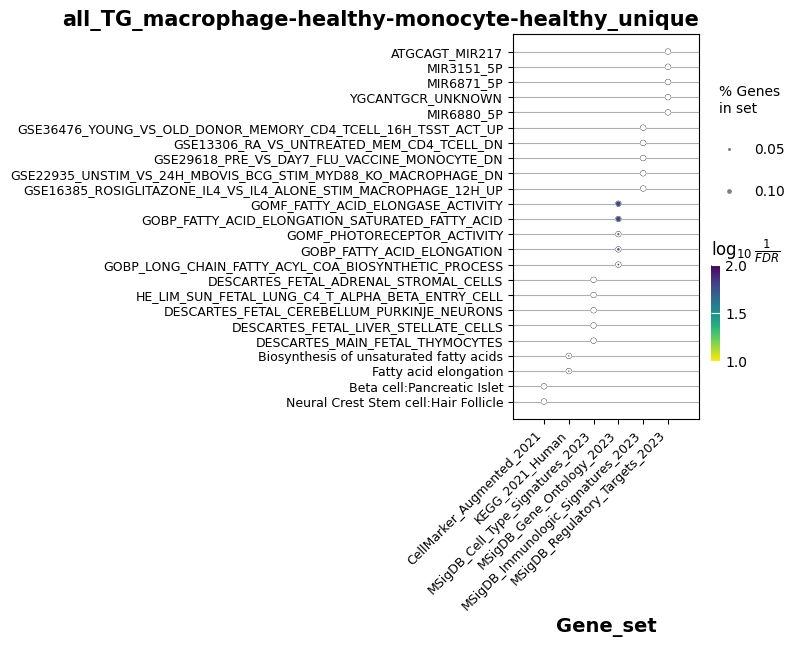

In [34]:
all_tg_results_dictionary = {}
for index, row in df_all_tg_unique_hgnc.iterrows():
    for tf_type in df_all_tg_unique_hgnc.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
        if len(genes) > 0:
            try:
                enr_bg = gp.enrichr(gene_list=genes,
                            gene_sets=normal_gene_sets,
                            organism='human', 
                            #background=all_tfs_adjusted,
                            outdir=None, # don't write to disk
                            )
                enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(normal_gene_sets_renaming)
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            #title = index+"_"+tf_type,
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                y_axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=y_axis_size)
                ax.tick_params(axis='x', labelsize=y_axis_size)
                ax.set_title("all_TG_"+index+"_"+tf_type, loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_all_TG_"+index+"_"+tf_type
                plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                all_tg_results_dictionary[index+"_"+tf_type] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+tf_type)
                print(ve)

In [41]:
macro_mono_results = all_tg_results_dictionary["macrophage-healthy-monocyte-healthy_unique"]
macro_mono_results[(macro_mono_results["Adjusted P-value"]<0.05)
        &(macro_mono_results["Gene_set"]=="MSigDB_Gene_Ontology_2023")].sort_values(by="Adjusted P-value").head(5)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
168,MSigDB_Gene_Ontology_2023,GOMF_FATTY_ACID_ELONGASE_ACTIVITY,1/7,0.000487,0.016574,4416.692308,33682.830136,ELOVL4
117,MSigDB_Gene_Ontology_2023,GOBP_FATTY_ACID_ELONGATION_SATURATED_FATTY_ACID,1/7,0.000487,0.016574,4416.692308,33682.830136,ELOVL4
123,MSigDB_Gene_Ontology_2023,GOBP_LONG_CHAIN_FATTY_ACYL_COA_BIOSYNTHETIC_PR...,1/19,0.001323,0.017991,1551.162162,10281.005168,ELOVL4
116,MSigDB_Gene_Ontology_2023,GOBP_FATTY_ACID_ELONGATION,1/13,0.000905,0.017991,2296.200000,16090.213170,ELOVL4
171,MSigDB_Gene_Ontology_2023,GOMF_PHOTORECEPTOR_ACTIVITY,1/16,0.001114,0.017991,1851.580645,12590.257823,ELOVL4


-> enriched sets for fat metabolism
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4808766/
Differential lipid metabolism in monocytes and macrophages: influence of cholesterol loading

https://www.google.com/search?q=monocyte+macrophage+fatty+acid+metabolism
What is the role of macrophages in lipid metabolism?
Macrophages take up LDL, VLDL and oxidised lipoproteins, via macropinocytosis, phagocytosis and scavenger receptor-mediated pathways (Fig. 1B) [29]. Ingested lipids are digested in the lysosome, generating free cholesterol and free fatty acids.
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6108423/


# TF + TG

In [19]:
df_tf_top_k_tg_hgnc = pd.DataFrame(index=tf_df_tpm_unique.index, columns=tf_df_tpm_unique.columns)
df_tf_all_tgs_hgnc = pd.DataFrame(index=tf_df_tpm_unique.index, columns=tf_df_tpm_unique.columns)
for row in tf_df_tpm_unique.index:
    for col in tf_df_tpm_unique.columns:
        df_tf_top_k_tg_hgnc.at[row, col] = tf_df_tpm_unique.at[row, col].union(df_top_k_tg_unique_hgnc.at[row, col])
        df_tf_all_tgs_hgnc.at[row, col] = tf_df_tpm_unique.at[row, col].union(df_all_tg_unique_hgnc.at[row, col])

Selecting only the rows were TG were found, so no redundant ORAs are performed on the unchanged sets  on TFs

In [20]:
df_tf_all_tgs_hgnc_selected = df_tf_all_tgs_hgnc.loc[["macrophage-healthy-monocyte-healthy", "t-cell-healthy-neutrophil-healthy"],:]

In [21]:
df_tf_all_tgs_hgnc_selected.applymap(lambda x: len(x))

,unique
macrophage-healthy-monocyte-healthy,11
t-cell-healthy-neutrophil-healthy,3


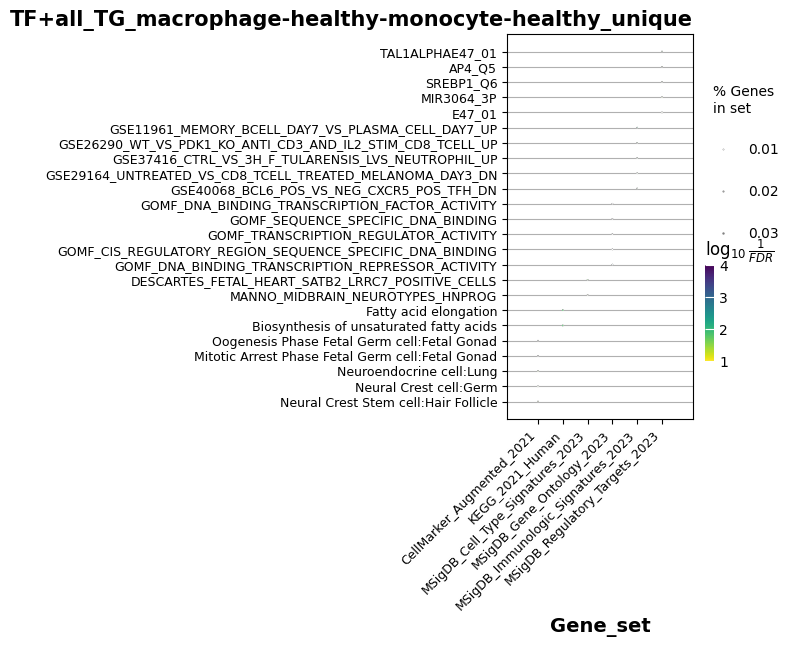

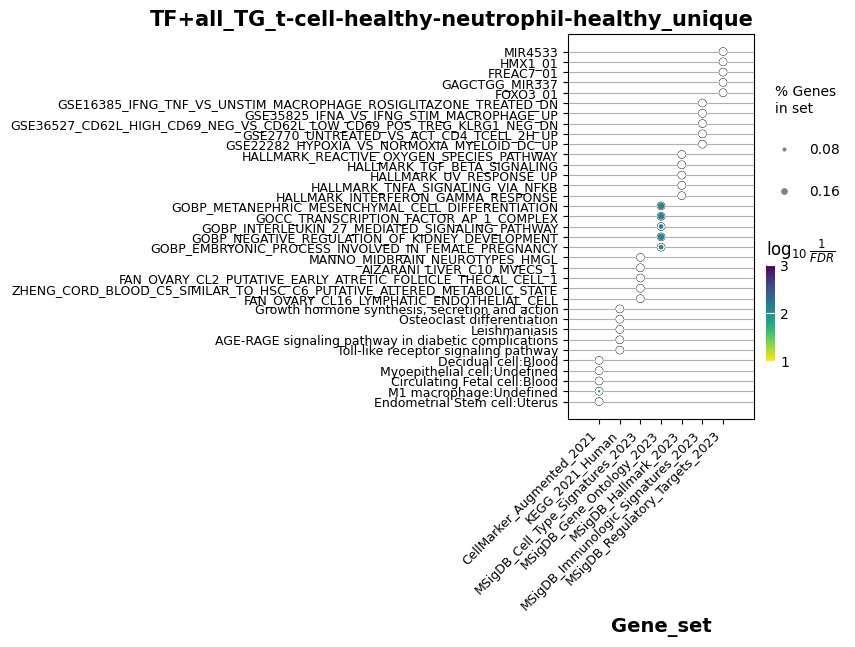

In [33]:
tf_all_tg_results_dictionary = {}
for index, row in df_tf_all_tgs_hgnc_selected.iterrows():
    for tf_type in df_tf_all_tgs_hgnc_selected.columns:
        genes = list(myfunc.adjust_tfprio_used_TF(row[tf_type]))
        if len(genes) > 1:
            enr_bg = gp.enrichr(gene_list=genes,
                        gene_sets=normal_gene_sets,
                        organism='human', 
                        #background=all_tfs_adjusted,
                        outdir=None, # don't write to disk
                        )
            enr_bg.results["Gene_set"] = enr_bg.results["Gene_set"].replace(normal_gene_sets_renaming)
            try:
                ax = gp.dotplot(enr_bg.results,
                            column="Adjusted P-value",
                            x='Gene_set', # set x axis, so you could do a multi-sample/library comparsion
                            size=4,
                            top_term=5,
                            figsize=(3,5),
                            #title = index+"_"+tf_type,
                            xticklabels_rot=45, # rotate xtick labels
                            show_ring=True, # set to False to revmove outer ring
                            marker='o',
                            )
                axis_size, title_size = myfunc.enrichr_adjust_y_axis_title_font_sizes(enr_bg.results)
                ax.tick_params(axis='y', labelsize=axis_size)
                ax.tick_params(axis='x', labelsize=axis_size)
                ax.set_title("TF+all_TG_"+index+"_"+tf_type, loc="right", fontsize=title_size,fontweight='bold')
                figure_file_name = "ORA_TF_all_TG_"+index+"_"+tf_type
                #plt.savefig(os.path.join(path_to_figure_folder, figure_file_name), bbox_inches='tight')
                tf_all_tg_results_dictionary[index+"_"+tf_type] = enr_bg.results
            except ValueError as ve:
                print("For "+str(index)+"_"+tf_type)
                print(ve)

In [62]:
tf_all_tg_results_dictionary["t-cell-healthy-neutrophil-healthy_unique"]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Odds Ratio,Combined Score,Genes
0,gs_ind_0,ACACTGG_MIR199A_MIR199B,1/159,0.011043,0.042223,180.167192,811.817752,JUNB
1,gs_ind_0,AHRR_TARGET_GENES,1/1405,0.095463,0.107946,19.444998,45.676708,STAT1
2,gs_ind_0,AREB6_04,1/253,0.017544,0.042223,112.722772,455.746135,JUNB
3,gs_ind_0,ARID5B_TARGET_GENES,1/944,0.064668,0.086420,29.434552,80.606306,STAT1
4,gs_ind_0,ATF5_TARGET_GENES,1/464,0.032056,0.062003,60.952535,209.693340,STAT1
...,...,...,...,...,...,...,...,...
943,gs_ind_6,Th17 cell differentiation,1/106,0.007369,0.015777,271.180095,1331.617232,STAT1
944,gs_ind_6,Thyroid hormone signaling pathway,1/121,0.008410,0.015777,237.298755,1133.899757,STAT1
945,gs_ind_6,Toll-like receptor signaling pathway,1/100,0.006953,0.015777,287.592965,1428.939494,STAT1
946,gs_ind_6,Toxoplasmosis,1/111,0.007716,0.015777,258.864253,1259.232106,STAT1


# searching for TGs of GFI1 because of known relation

In [23]:
gfi1_tf_df = tf_df_tpm_unique.loc[["b-cells-healthy-t-cell-healthy"]]
gfi1_tf_df

,unique
b-cells-healthy-t-cell-healthy,{GFI1}


In [24]:
gfi1_tg_df = pd.DataFrame.from_dict(myfunc.read_out_filtered_target_genes_dict(gfi1_tf_df, path_to_main_comparison_dir, modus="all_genes",  affinity_filter_value = 0.001 ), orient="index")


In [50]:
print(len(set(gfi1_tg_df["unique"][0])))
gfi1_tg_df_hgnc = gfi1_tg_df.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))
gfi1_tgs = gfi1_tg_df_hgnc["unique"][0]
print("ID1" in gfi1_tgs)
print("ID2" in gfi1_tgs)

4597
False
False


In [45]:
gfi1_tg_df_0 = pd.DataFrame.from_dict(myfunc.read_out_filtered_target_genes_dict(gfi1_tf_df, path_to_main_comparison_dir, modus="all_genes",  affinity_filter_value = 0.00 ), orient="index")


In [51]:
print(len(set(gfi1_tg_df_0["unique"][0])))
gfi1_tg_df_0_hgnc = gfi1_tg_df_0.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))
gfi1_tgs = gfi1_tg_df_0_hgnc["unique"][0]
print("ID1" in gfi1_tgs)
print("ID2" in gfi1_tgs)

56735
True
True


In [36]:
gfi1_tg_df_hgnc = gfi1_tg_df.applymap(lambda x: myfunc.convert_ensg_to_hgnc(x, gtf_dict))

In [38]:
gfi1_tgs = gfi1_tg_df_hgnc["unique"][0]

In [40]:
print("ID1" in gfi1_tgs)
print("ID2" in gfi1_tgs)

False
False


In [44]:
"ID2" in gtf_dict.values()

True